In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import nltk
nltk.download("stopwords") # 下载停用词
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer # 提取词干

2023-10-30 10:30:55.464285: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to /Users/wzzzz/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
SnowballStemmer.languages # 支持的语言

('arabic',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'hungarian',
 'italian',
 'norwegian',
 'porter',
 'portuguese',
 'romanian',
 'russian',
 'spanish',
 'swedish')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print("Tensorflow version : ", tf.__version__)

Tensorflow version :  2.12.0


In [5]:
# 加载数据集
dataset = pd.read_csv("training.1600000.processed.noemoticon.csv", engine="python", header=None, encoding='ISO-8859-1')

In [6]:
# 默认显示前5行
dataset.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
# 为数据集重置表头 header
dataset.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']

dataset.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
# 丢弃无用的列
df = dataset.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [10]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [11]:
# 查看标签类别
df['sentiment'].value_counts()

sentiment
0    800000
4    800000
Name: count, dtype: int64

### 文本预处理

#### 1. 词干提取  + 词形还原
#### 2. 超链接 + @某人
#### 3. 停用词（无实际意义词）

In [12]:
# 停用词
stop_words = stopwords.words("english")

In [13]:
# 词干
stemmer = SnowballStemmer('english')

In [14]:
# 正则化表达式
text_cleaning_re = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'

In [15]:
# 对文本进行清洗
import re

def preprocessing(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token)) # 提取词干
            else:
                tokens.append(token) # 直接保存单词
    return ' '.join(tokens)

In [16]:
# 一个原始样本
df.text[2]

'@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'

In [17]:
# 对数据集中的text列中每行文本进行清洗
df.text = df.text.apply(lambda x : preprocessing(x))

In [18]:
# 清洗后的样本
df.text[2]

'dived many times ball managed save 50 rest go bounds'

In [19]:
MAX_WORDS = 100000 # 最大词汇量10万
MAX_SEQ_LENGTH = 30 # 最大序列长度30

In [20]:
# train, test 分离

train_dataset, test_dataset = train_test_split(df, test_size = 0.2, random_state = 666, shuffle=True)

In [21]:
train_dataset.shape

(1280000, 2)

In [22]:
test_dataset.shape

(320000, 2)

In [23]:
# 训练集默认前5行
train_dataset.head()

,sentiment,text
812696,4,want ui freebie input gladly pass along develo...
323260,0,new super mario wii looks lame
1174876,4,ate blizzard breakfast
1528480,4,rdeutz sun however greece hot 30 celcius perha...
972505,4,hey love pic glowing hotness glad stalking


In [24]:
# 测试集默认前5行
test_dataset.head()

,sentiment,text
473,0,quot popular music quot w adorno probably diff...
930692,4,ahhh righty im fine
1183094,4,waaaay ahead
1553463,4,watching hugh laurie quot inside actor studio ...
106190,0,walk


In [25]:
# 分词

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_dataset.text)

In [26]:
# 每个单词对应一个索引

word_index = tokenizer.word_index

In [27]:
# 训练集词汇表大小
vocab_size = len(word_index) + 1

vocab_size

290683

In [28]:
# 固定每一条文本的长度
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_dataset.text),
                        maxlen=MAX_SEQ_LENGTH)

x_test = pad_sequences(tokenizer.texts_to_sequences(test_dataset.text),
                       maxlen=MAX_SEQ_LENGTH)

In [29]:
x_train.shape

(1280000, 30)

In [30]:
x_test.shape

(320000, 30)

In [31]:
# 标签类别进行LabelEncoding，将类别编码成连续的编号

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y_train = encoder.fit_transform(train_dataset.sentiment.tolist())

y_test = encoder.fit_transform(test_dataset.sentiment.tolist())

In [32]:
y_train = y_train.reshape(-1, 1) # shape 转置

In [33]:
y_train.shape

(1280000, 1)

In [34]:
y_test = y_test.reshape(-1, 1)

In [35]:
y_test.shape

(320000, 1)

In [37]:
# word embedding 词嵌入 ： 将单词用特征向量来表示，这里使用预训练的词向量 GloVe

GloVe = "glove.6B.300d.txt"

EMBEDDING_DIM = 300 # 300 维

BATCH_SIZE = 10000 # 批处理的大小

EPOCHS = 10 # 循环的次数
 
LR = 1e-3 # 学习率

MODEL_PATH = "./best_model.hdf5" # 保存模型路径

In [38]:
# 构建字典： 格式： { 单词 ： 词嵌入向量}

embedding_index = {}

with open(GloVe) as f:
    for line in f:
        values = line.split() # 按空格分割
        word = values[0] # 第一个位置上是单词
        embeddings = np.asarray(values[1:], dtype="float32") # 每个单词对应的词嵌入
        embedding_index[word] = embeddings # 键值对

In [39]:
len(embedding_index) # 单词数

400000

In [40]:
# 获取词嵌入矩阵

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM)) # vocab_size : 训练集词汇表大小，EMBEDDING_DIM : 词嵌入维度

num = 0

for word, values in embedding_index.items():
    embedding_vector = embedding_index.get(word) # 单词对应的词嵌入向量
    if embedding_vector is not None:
        if num < vocab_size:
            embedding_matrix[num, :] = embedding_vector
        num += 1

In [41]:
embedding_matrix.shape

(290683, 300)

### 搭建模型

In [42]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D # 丢弃整个1D的特征图而不是丢弃单个元素，提高特征图之间的独立性
from tensorflow.keras.callbacks import ModelCheckpoint


In [43]:
sequence_input = Input(shape=(MAX_SEQ_LENGTH, ), dtype='int32') # 设置输入序列长度 MAX_SEQ_LENGTH


In [44]:
embedding_layer = Embedding(vocab_size, # 词汇表大小
                            EMBEDDING_DIM, # 词嵌入维度
                            weights = [embedding_matrix], # 预训练词嵌入
                            input_length = MAX_SEQ_LENGTH, # 序列长度
                            trainable = False)


In [45]:
embedding_sequences = embedding_layer(sequence_input)

x = SpatialDropout1D(0.2)(embedding_sequences)
print(x.shape)
x = Conv1D(64, 5, activation='relu')(x)
print(x.shape)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
print(x.shape)
x = Dense(512, activation='relu')(x)
print(x.shape)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
print(x.shape)
outputs = Dense(1, activation='sigmoid')(x)
print(outputs.shape)
model = tf.keras.Model(sequence_input, outputs)

(None, 30, 300)
(None, 26, 64)
(None, 128)
(None, 512)
(None, 512)
(None, 1)


In [46]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 模型变异
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])

ReduceLR = ReduceLROnPlateau(factor=0.1, min_lr=0.01, monitor='val_loss', verbose=1)
# factor : 学习速率被降低的因数， 新的学习速率 = 学习率 * 因素
# min_lr : 学习率的下边界
# monitor : 被监测的数据

[了解callback 回调函数，请参考这两个链接]
[链接1](https://zhuanlan.zhihu.com/p/52141518)
[链接2](https://keras.io/zh/callbacks/)

In [47]:
# 模型训练

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test),
                    callbacks=[ReduceLR])

Epoch 1/10
128/128 [==============================] - 376s 3s/step - loss: 0.6501 - accuracy: 0.6056 - val_loss: 0.5888 - val_accuracy: 0.6841 - lr: 0.0010
Epoch 2/10
128/128 [==============================] - 352s 3s/step - loss: 0.5829 - accuracy: 0.6842 - val_loss: 0.5531 - val_accuracy: 0.7108 - lr: 0.0010
Epoch 3/10
128/128 [==============================] - 386s 3s/step - loss: 0.5555 - accuracy: 0.7089 - val_loss: 0.5279 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 4/10
128/128 [==============================] - 366s 3s/step - loss: 0.5410 - accuracy: 0.7212 - val_loss: 0.5170 - val_accuracy: 0.7378 - lr: 0.0010
Epoch 5/10
128/128 [==============================] - 351s 3s/step - loss: 0.5304 - accuracy: 0.7295 - val_loss: 0.5112 - val_accuracy: 0.7430 - lr: 0.0010
Epoch 6/10
128/128 [==============================] - 358s 3s/step - loss: 0.5237 - accuracy: 0.7347 - val_loss: 0.5061 - val_accuracy: 0.7471 - lr: 0.0010
Epoch 7/10
128/128 [==============================] - 349s 3s/st

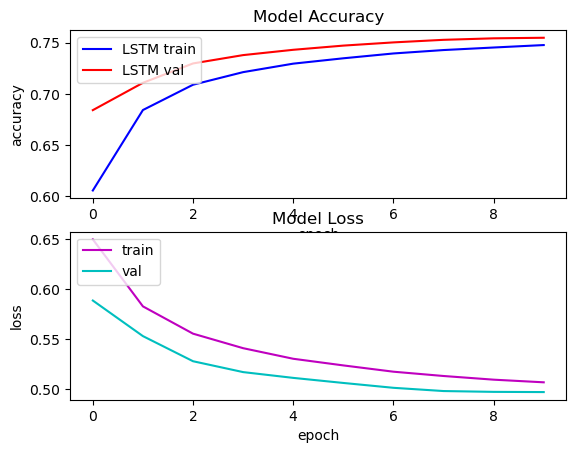

In [48]:
# 绘制训练和验证结果

s, (one, two) = plt.subplots(2, 1)

one.plot(history.history['accuracy'], c='b')
one.plot(history.history['val_accuracy'], c='r')
one.set_title('Model Accuracy')
one.set_ylabel("accuracy")
one.set_xlabel("epoch")
one.legend(['LSTM train', 'LSTM val'], loc='upper left')

two.plot(history.history['loss'], c='m')
two.plot(history.history['val_loss'], c='c')
two.set_title('Model Loss')
two.set_ylabel('loss')
two.set_xlabel('epoch')
two.legend(['train', 'val'], loc='upper left')

In [49]:
# 模型的输出概率在 0 - 1 之间，这里我们设定一个阈值： 0.5， 如果概率 > 0.5，则会 正面，否则，为负面评论

def Judge(score):
    return 1 if score > 0.5 else 0

In [50]:
# 模型在test上预测

scores = model.predict(x_test, verbose=1, batch_size=10000)

32/32 [==============================] - 21s 645ms/step


In [51]:
# 最终的预测结果

y_pred = [Judge(score) for score in scores]

In [49]:
y_pred

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,


In [52]:
y_test.squeeze()

array([0, 1, 1, ..., 1, 0, 0])

In [53]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.subplots as tls
import plotly.figure_factory as ff
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_ROC_AUC(y_test, y_pred):
    fpr, tpr, t = roc_curve(y_test, y_pred)
    model_roc_auc = roc_auc_score(y_test, y_pred) # 得分
    trace = go.Scatter(x = fpr, y = tpr,
                       name = "ROC : " + str(model_roc_auc),
                       line = dict(color=('rgb(22, 96, 167)'), width = 2), fill = 'tozeroy')
    fig = tls.make_subplots(rows=1, cols=1, print_grid=False, subplot_titles=("ROC_AUC_curve",))
    fig.append_trace(trace,1,1)
    fig.layout.xaxis.update(dict(title="FPR"), range=[0, 1.05])
    fig.layout.yaxis.update(dict(title="TPR", range=[0, 1.05]))
    fig.layout.titlefont.size = 14 # 标题字体大小
    py.iplot(fig)
    
plot_ROC_AUC(y_test.squeeze(), y_pred)

In [54]:
# 模型性能评估
from sklearn.metrics import confusion_matrix
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.subplots as tls
import plotly.figure_factory as ff

def show_matrics(y_test, y_pred):
    # 计算混淆矩阵
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix, x = ["0(pred)", "1(pred)"],
                       y = ["0(True)", "1(True)"], xgap = 2, ygap = 2,
                       colorscale = 'Viridis', showscale = False)
    # 根据混淆矩阵，获取对应的参数值
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    FP = conf_matrix[0, 1]
    TN = conf_matrix[0, 0]
    
    # 计算accuracy, precision, recall, f1_score
    accuracy = (TP + TN) / (TP + TN + FP + FN) # 准确率
    precision = TP / (TP + FP) # 精准率
    recall = TP / (TP + FN) # 召回率
    F1_score = 2 * precision * recall / (precision + recall)
    
    # 显示以上四个指标
    show_metrics = pd.DataFrame(data = [[accuracy, precision, recall, F1_score]])
    show_metrics = show_metrics.T
    
    # 可视化显示
    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = show_metrics[0].values,
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score'],
                    text = np.round_(show_metrics[0].values, 4),
                    textposition = 'auto',
                    orientation = 'h',
                    opacity = 0.8,
                    marker = dict(color = colors, line = dict(color="#000000", width=1.5)))
    
    fig = tls.make_subplots(rows=2, cols=1, subplot_titles=('Confusion Matrix', 'Metrics'))
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 2, 1)
    py.iplot(fig)


show_matrics(y_test.squeeze(), y_pred)

In [55]:
# 保存模型
model.save("./BiLSTM_model.h5")

### 模型2 ： LSTM 网络

In [56]:
from tensorflow.keras import Sequential

model_lstm = Sequential()

# 添加 embedding 层
model_lstm.add(embedding_layer)

# 添加Dropout
model_lstm.add(Dropout(0.5))

# 添加LSTM
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# 添加全连接层
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           87204900  
                                                                 
 dropout_1 (Dropout)         (None, 30, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 87,365,401
Trainable params: 160,501
Non-trainable params: 87,204,900
_________________________________________________________________


In [57]:
# 模型编译

model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [58]:
from tensorflow.keras.callbacks import EarlyStopping

history = model_lstm.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                         validation_data=(x_test, y_test),
                         verbose=1,
                         callbacks=EarlyStopping(patience=10, monitor='val_loss'))

Epoch 1/10
128/128 [==============================] - 356s 3s/step - loss: 0.6608 - accuracy: 0.5945 - val_loss: 0.6078 - val_accuracy: 0.6696
Epoch 2/10
128/128 [==============================] - 354s 3s/step - loss: 0.6075 - accuracy: 0.6631 - val_loss: 0.5646 - val_accuracy: 0.7061
Epoch 3/10
128/128 [==============================] - 364s 3s/step - loss: 0.5826 - accuracy: 0.6863 - val_loss: 0.5416 - val_accuracy: 0.7242
Epoch 4/10
128/128 [==============================] - 365s 3s/step - loss: 0.5696 - accuracy: 0.6981 - val_loss: 0.5330 - val_accuracy: 0.7303
Epoch 5/10
128/128 [==============================] - 364s 3s/step - loss: 0.5612 - accuracy: 0.7050 - val_loss: 0.5248 - val_accuracy: 0.7366
Epoch 6/10
128/128 [==============================] - 376s 3s/step - loss: 0.5554 - accuracy: 0.7094 - val_loss: 0.5187 - val_accuracy: 0.7414
Epoch 7/10
128/128 [==============================] - 347s 3s/step - loss: 0.5509 - accuracy: 0.7130 - val_loss: 0.5181 - val_accuracy: 0.7415

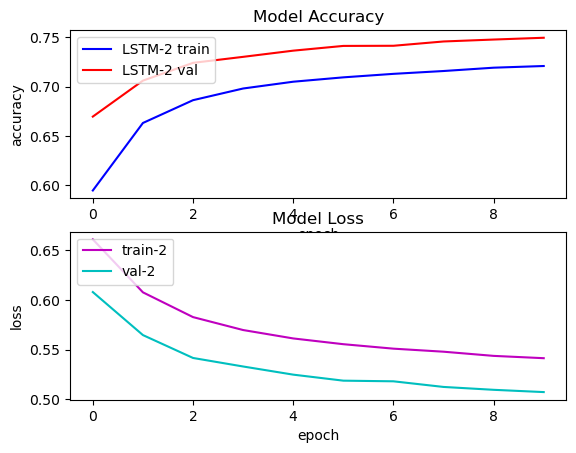

In [60]:
# 绘制训练和验证结果

s, (one, two) = plt.subplots(2, 1)

one.plot(history.history['accuracy'], c='b')
one.plot(history.history['val_accuracy'], c='r')
one.set_title('Model Accuracy')
one.set_ylabel("accuracy")
one.set_xlabel("epoch")
one.legend(['LSTM-2 train', 'LSTM-2 val'], loc='upper left')

two.plot(history.history['loss'], c='m')
two.plot(history.history['val_loss'], c='c')
two.set_title('Model Loss')
two.set_ylabel('loss')
two.set_xlabel('epoch')
two.legend(['train-2', 'val-2'], loc='upper left')

In [61]:
# 保存模型
model.save("./LSTM_model.h5")

### 2个模型进行预测比较

In [62]:
def predict(input_text):
    # 分词 tokenization
    text_tokens = pad_sequences(tokenizer.texts_to_sequences([input_text]), maxlen=MAX_SEQ_LENGTH)
    # 模型预测
    ## 模型-1 双向LSTM
    score1 = model.predict([text_tokens])[0] # 返回概率
    ## 模型-2 单个LSTM
    score2 = model_lstm.predict([text_tokens])[0]
    
    # 根据阈值，判断是否是正面
    label_1 = Judge(score1)
    label_2 = Judge(score2)
    
    return {"label - 1" : label_1, "score - 1" : score1,
            "label - 2" : label_2, "score - 2" : score2}

In [65]:
text = "111"

In [66]:
predict(text) # 1 : positive, 0 : negative

1/1 [==============================] - 0s 22ms/step


{'label - 1': 1,
 'score - 1': array([0.6474507], dtype=float32),
 'label - 2': 1,
 'score - 2': array([0.62332445], dtype=float32)}